In [6]:
import torch
from torch import nn
from d2l import torch as d2l

from torch.nn import functional as F

In [12]:
class Residual(nn.Module):
    def __init__(self, input_channels, output_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, output_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None

        self.bn1 = nn.BatchNorm2d(output_channels)
        self.bn2 = nn.BatchNorm2d(output_channels)

    def forward(self, x):
        Y = F.relu(self.bn1(self.conv1(x)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            x = self.conv3(x)
        Y += x
        return F.relu(Y)

In [14]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

In [15]:
def resnet_block(input_channels, output_channels, num_residuals, first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, output_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(output_channels, output_channels))
    return blk

In [16]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [18]:
net = nn.Sequential(
    b1, b2, b3, b4, b5,
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten(),
    nn.Linear(512, 10)
    )

In [19]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, '\t', X.shape)

Sequential 	 torch.Size([1, 64, 56, 56])
Sequential 	 torch.Size([1, 64, 56, 56])
Sequential 	 torch.Size([1, 128, 28, 28])
Sequential 	 torch.Size([1, 256, 14, 14])
Sequential 	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d 	 torch.Size([1, 512, 1, 1])
Flatten 	 torch.Size([1, 512])
Linear 	 torch.Size([1, 10])


In [33]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size, resize=224)

training on cpu


KeyboardInterrupt: 

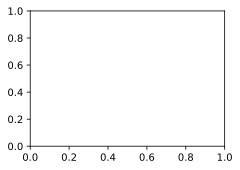

In [34]:
lr, num_epochs = 0.01, 10
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())